# [E14] 주식 예측에 도전해보자

### 목차
1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기
8. 회고

---
### 루브릭 평가 기준
1. 시계열의 안정성이 충분히 확인되었는가?
    * 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
    * p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
    * 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

## 1. 시계열 데이터 준비

* column 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 이번 예제에서는 Close만을 사용하여 주가를 예측할 계획

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-03    82000.0
2020-09-04    80400.0
2020-09-07    78400.0
2020-09-08    78000.0
2020-09-09    76800.0
Name: Close, dtype: float64

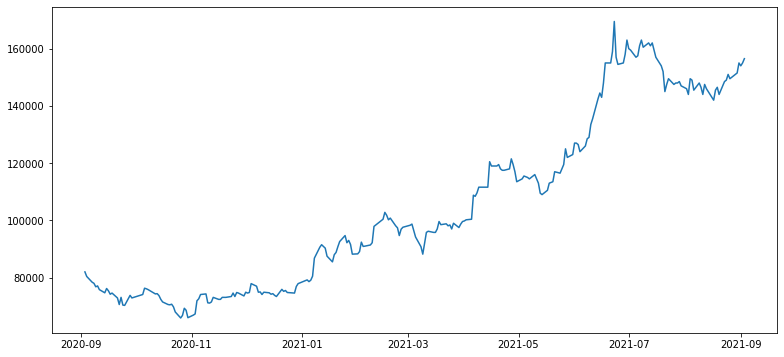

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

## 2. 각종 전처리 수행

In [3]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

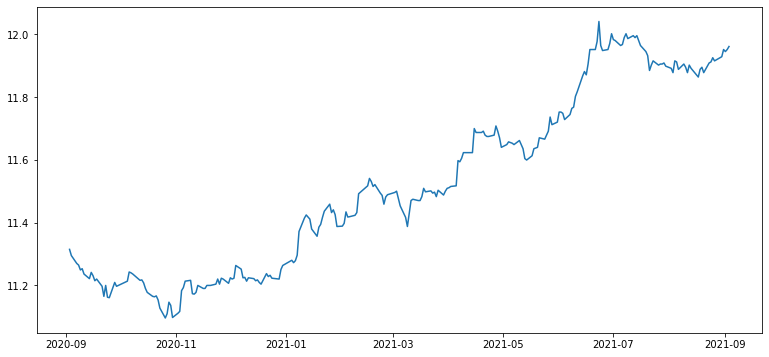

In [4]:
# 로그 변환
ts_log = np.log(ts)
plt.plot(ts_log)

## 3. 시계열 안정성 분석

In [5]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

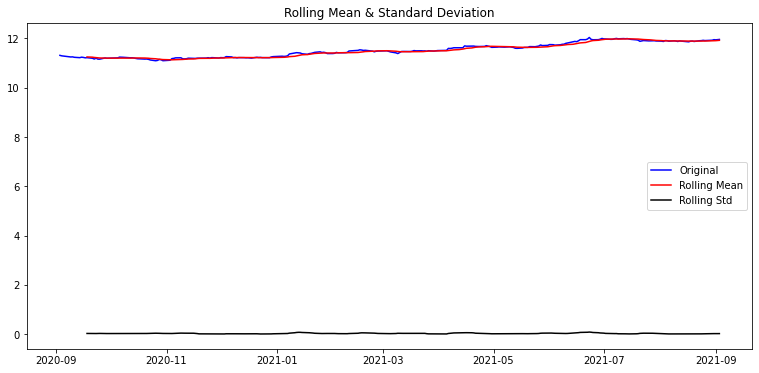

Results of Dickey-Fuller Test:
Test Statistic                   0.122127
p-value                          0.967540
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


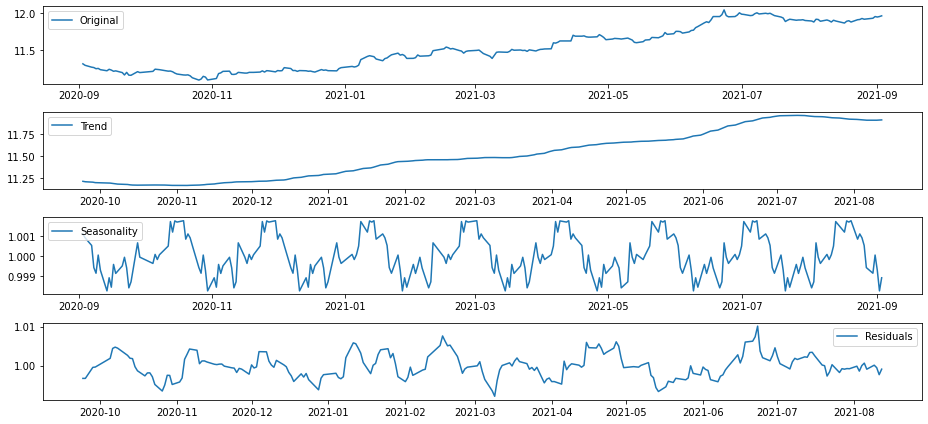

In [7]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.354209
p-value                          0.000004
#Lags Used                       1.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


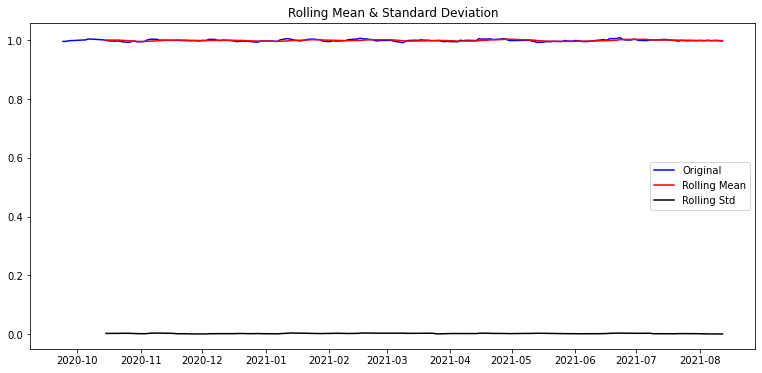

In [9]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

## 4. 학습, 테스트 데이터셋 생성

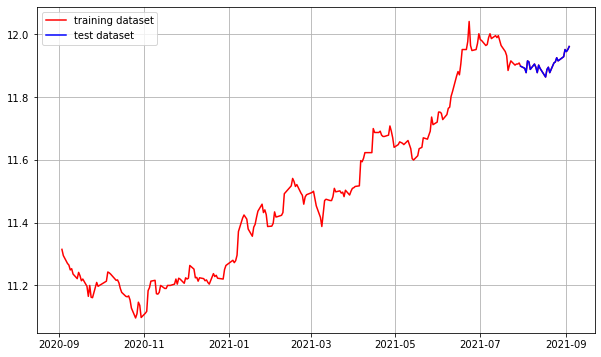

In [10]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 5. 적정 ARIMA 모수 찾기

* 적절한 ARIMA 모수를 찾기 위해서, 1차 차분과 2차 차분을 이용
* 로그 변환을 한 데이터, 1차 차분한 데이터, 2차 차분한 데이터 각각의 ACF와 PACF 그래프를 그림
* ACF와 PACF 그래프를 확인했을 때, 1차 차분을 한 데이터의 경우, 모두 금방 0에 수렴하고, 대부분의 데이터들이 파란 범주 안에 포함되는 것을 확인
* 따라서, ARIMA의 p와 q 값을 1, 1로 설정하는 것이 좋다고 판단
* d 값을 설정하기 위해서, 1차 차분과 2차 차분을 비교했지만, 두 데이터가 비슷한 양상으로 그려졌으며, d를 판단하기 위한 차분의 정상성을 이해하지 못했기에 d값을 1과 2 모두 사용하여 결과 값을 비교할 예정

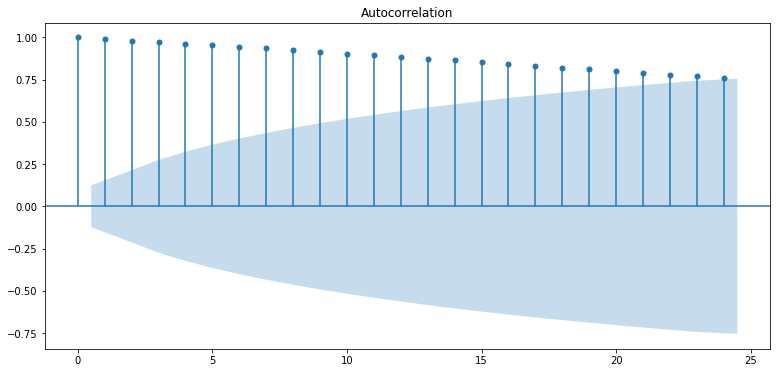

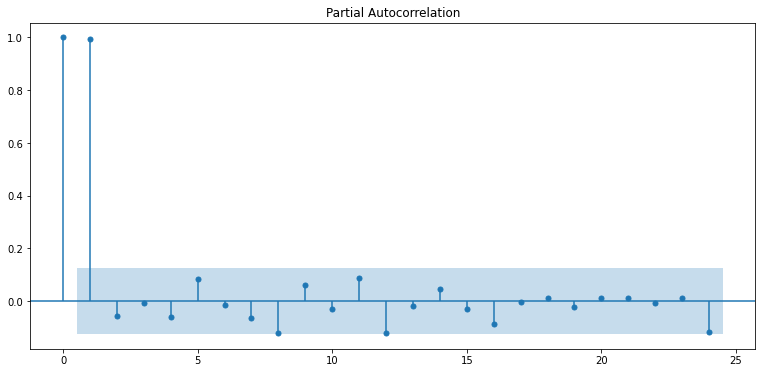

In [11]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.468064e+01
p-value                        3.160190e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


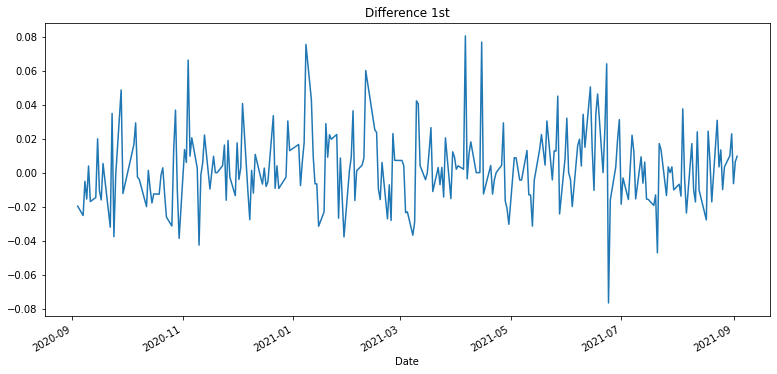

In [12]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

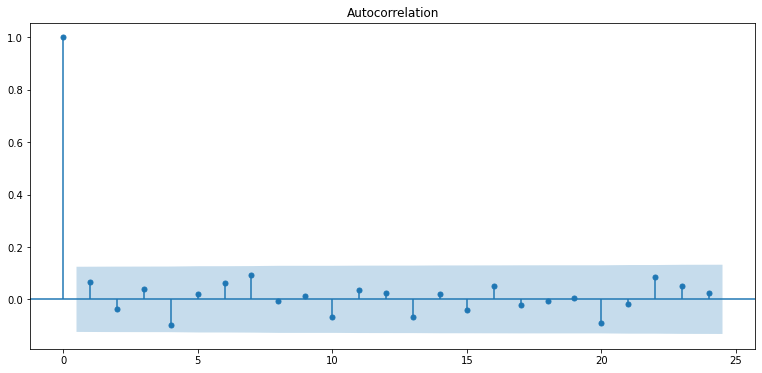

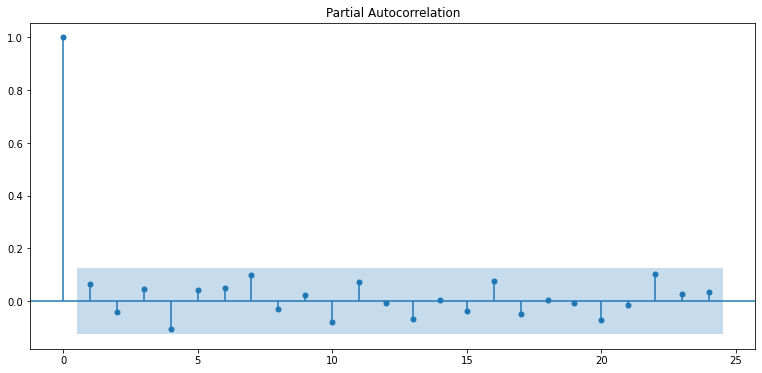

In [14]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -8.370761e+00
p-value                        2.666238e-13
#Lags Used                     9.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


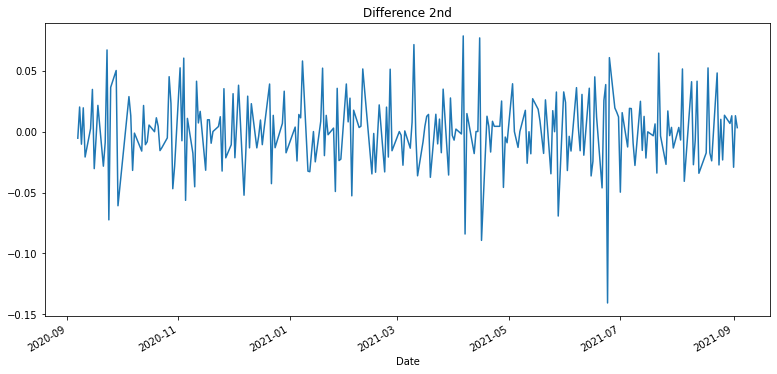

In [13]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

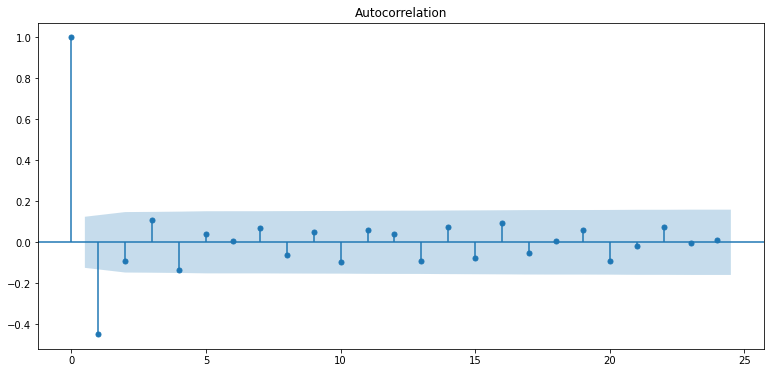

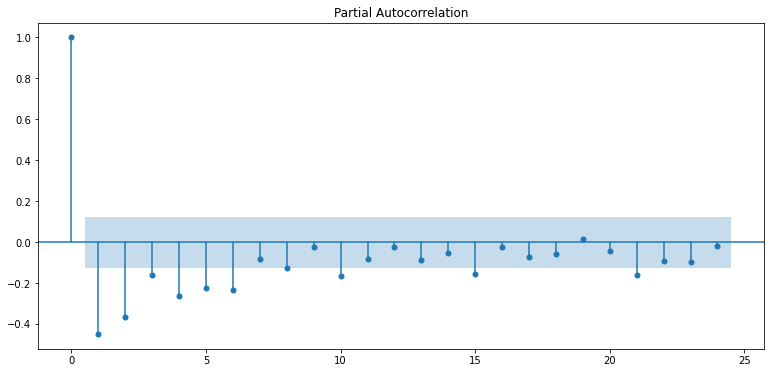

In [15]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [16]:
# from pmdarima import auto_arima
# auto_arima(ts_log)

## 6. ARIMA 모델 훈련과 테스트

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 531.290
Method:                       css-mle   S.D. of innovations              0.022
Date:                Tue, 07 Sep 2021   AIC                          -1054.579
Time:                        04:12:51   BIC                          -1040.950
Sample:                             1   HQIC                         -1049.077
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.001      3.043      0.002       0.001       0.005
ar.L1.D.Close     0.9878      0.017     58.490      0.000       0.955       1.021
ma.L1.D.Close    -1.0000      0.011    -

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

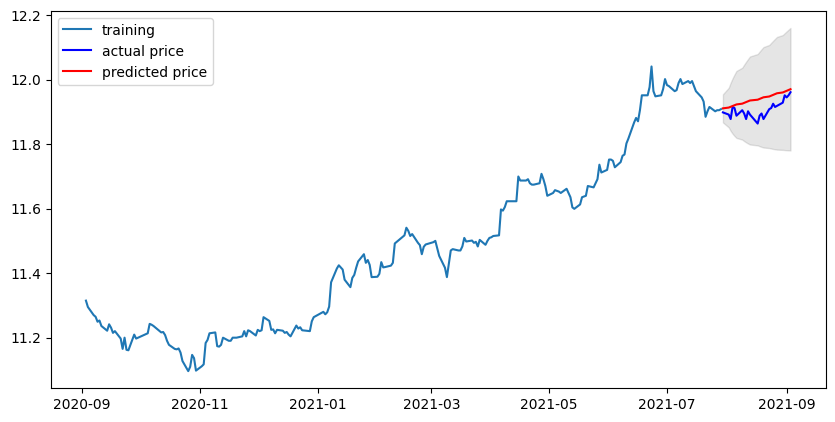

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30728509.548723783
MAE:  4888.166365151714
RMSE:  5543.330185792994
MAPE: 3.32%


* p=1, d=1, q=0 -> MAPE: 3.61%
* p=1, d=1, q=1 -> MAPE: 3.32%
* q=1, d=2, q=0 -> MAPE: 4.50%
* q=1, d=2, q=1 -> MAPE: 8.73%

## 7. 다른 주식 종목 예측해보기

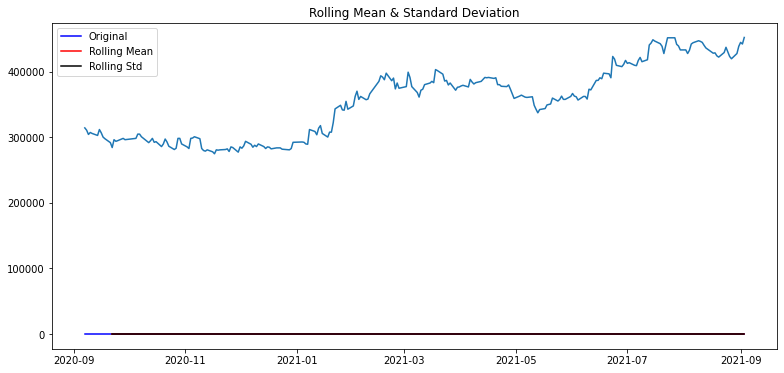

Results of Dickey-Fuller Test:
Test Statistic                  -0.357588
p-value                          0.916943
#Lags Used                       2.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.578795e+00
p-value                        7.605933e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


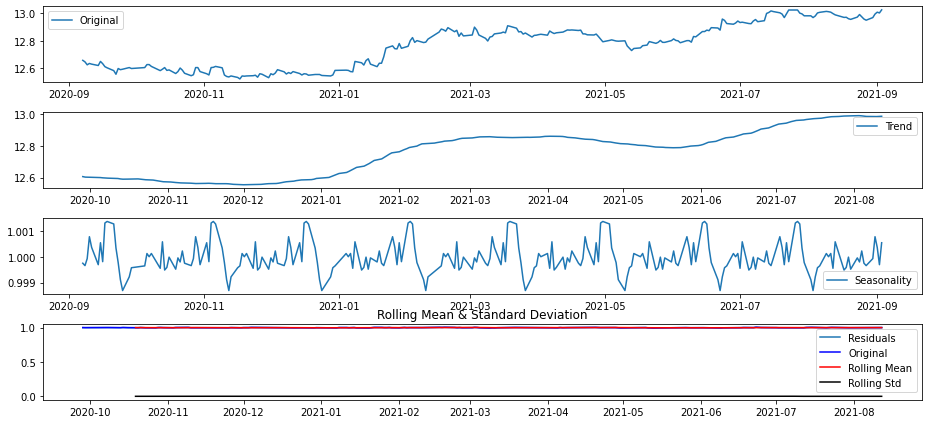

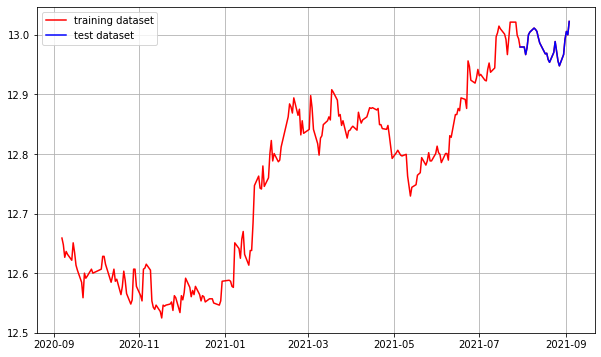

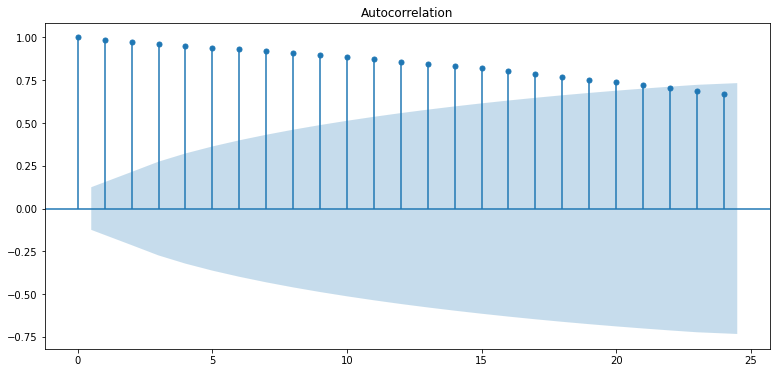

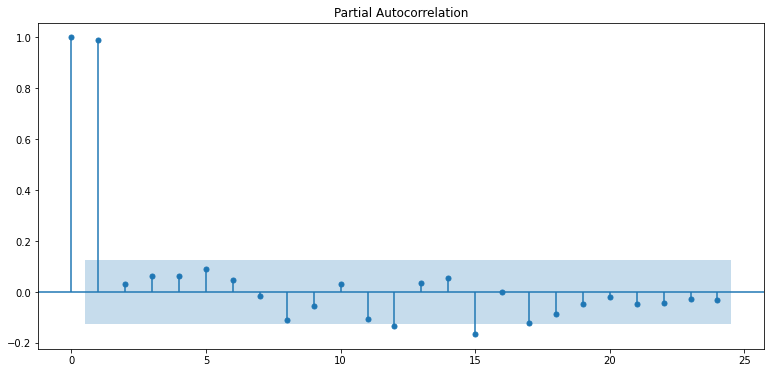

Results of Dickey-Fuller Test:
Test Statistic                -1.266271e+01
p-value                        1.294516e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


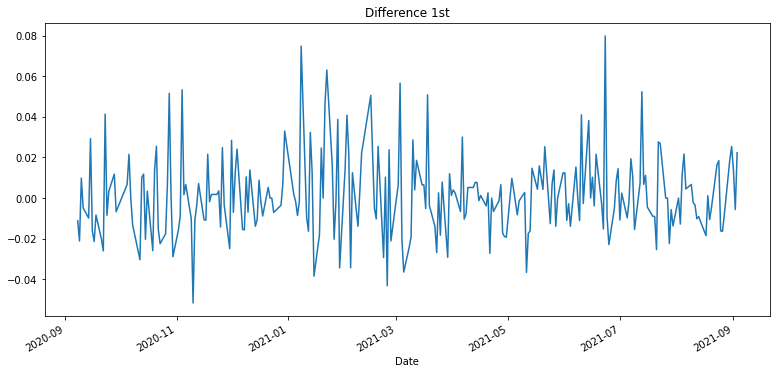

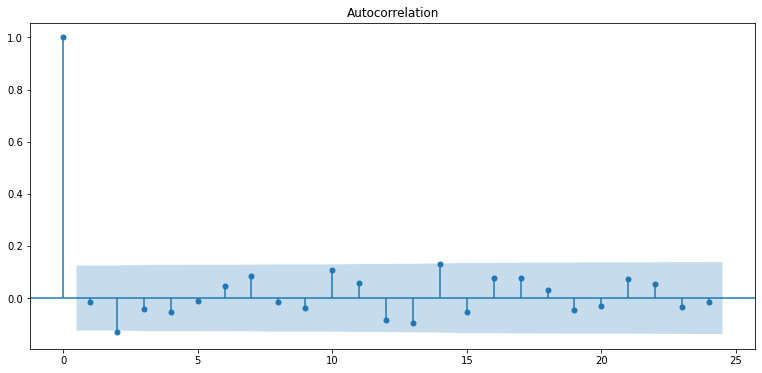

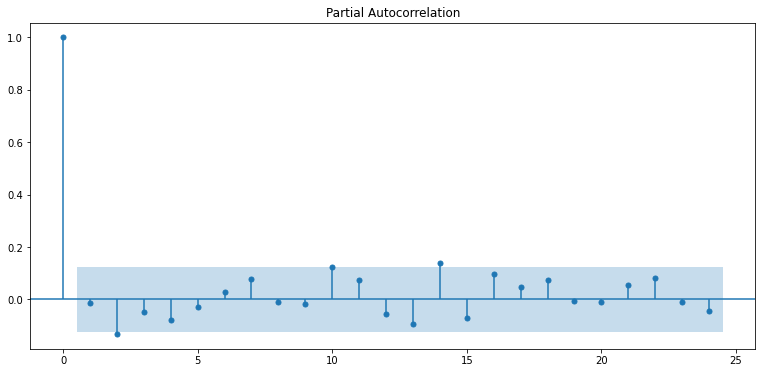

Results of Dickey-Fuller Test:
Test Statistic                -6.930112e+00
p-value                        1.089601e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.280000e+02
Critical Value (1%)           -3.459361e+00
Critical Value (5%)           -2.874302e+00
Critical Value (10%)          -2.573571e+00
dtype: float64


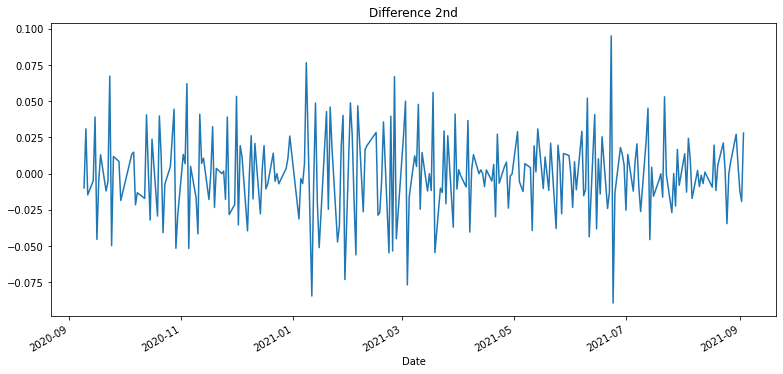

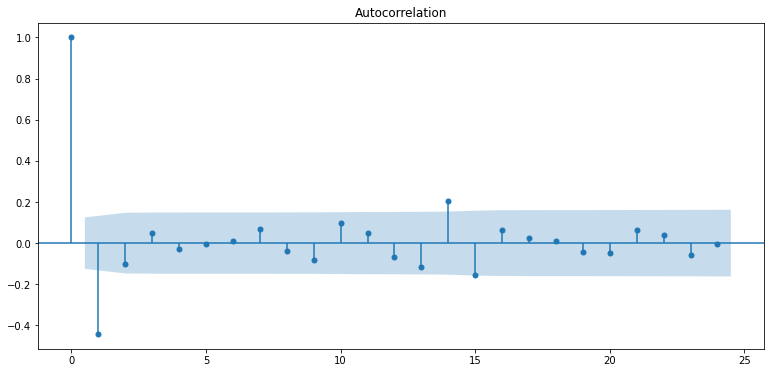

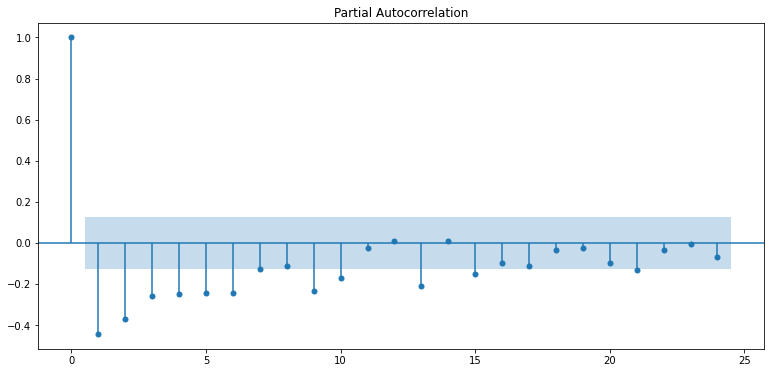

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 542.966
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 07 Sep 2021   AIC                          -1079.932
Time:                        04:12:54   BIC                          -1069.737
Sample:                             1   HQIC                         -1075.815
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0015      0.001      1.120      0.263      -0.001       0.004
ar.L1.D.Close    -0.0297      0.067     -0.442      0.658      -0.161       0.102
                                    Root

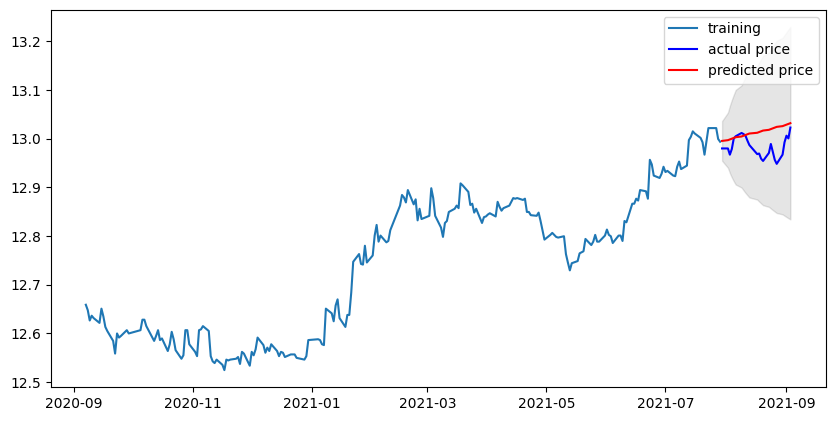

MSE:  273121371.38867277
MAE:  13484.391961321118
RMSE:  16526.384099030034
MAPE: 3.14%


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.


# 로그 변환
ts_log = np.log(ts)


# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

* p=1, d=1, q=0 -> MAPE: 3.14%
* p=1, d=1, q=1 -> MAPE: 3.51%
* q=1, d=2, q=0 -> MAPE: 12.01%
* q=1, d=2, q=1 -> MAPE: 계산 불가

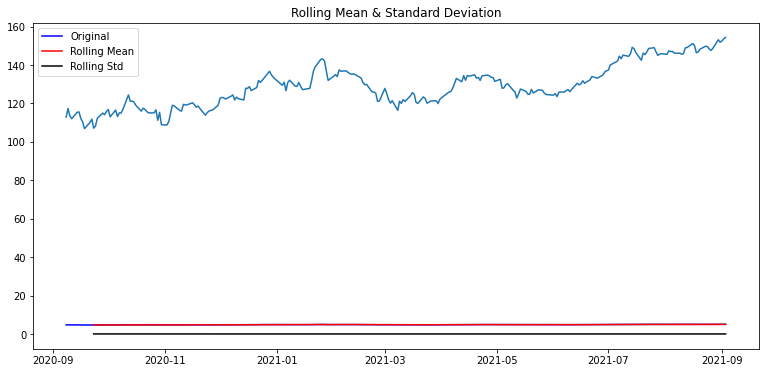

Results of Dickey-Fuller Test:
Test Statistic                  -0.964137
p-value                          0.766119
#Lags Used                       1.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.416770
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


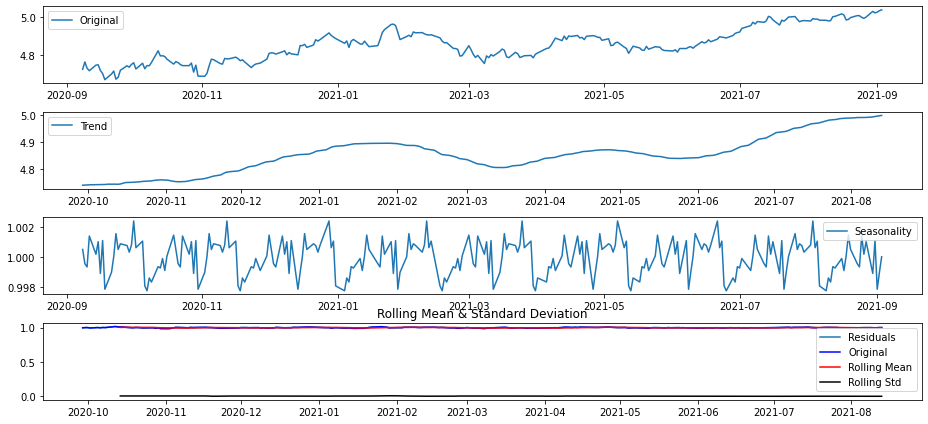

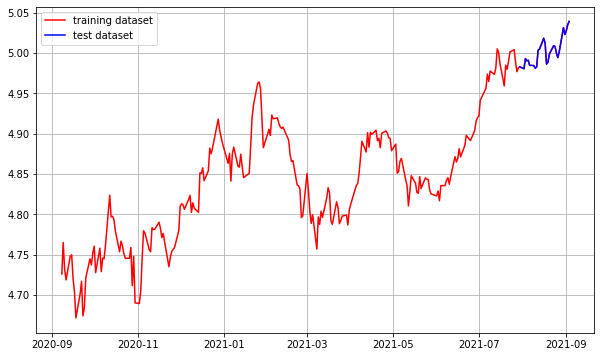

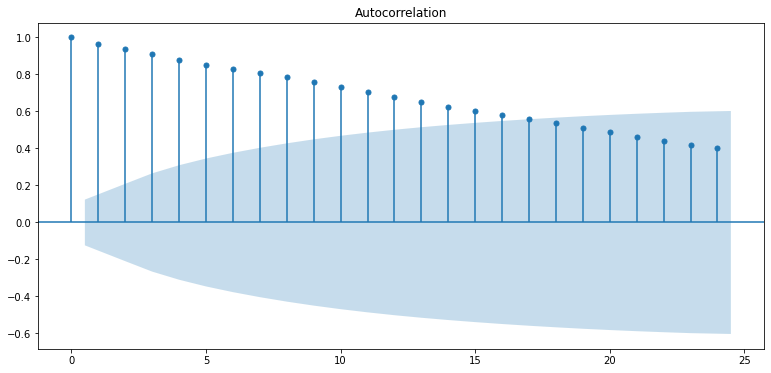

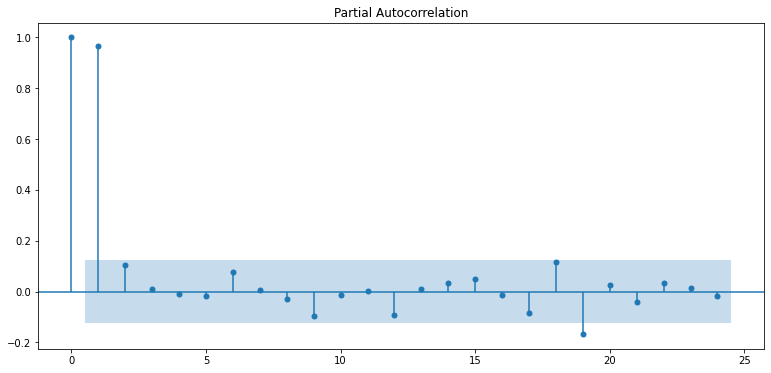

Results of Dickey-Fuller Test:
Test Statistic                -1.773999e+01
p-value                        3.405496e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


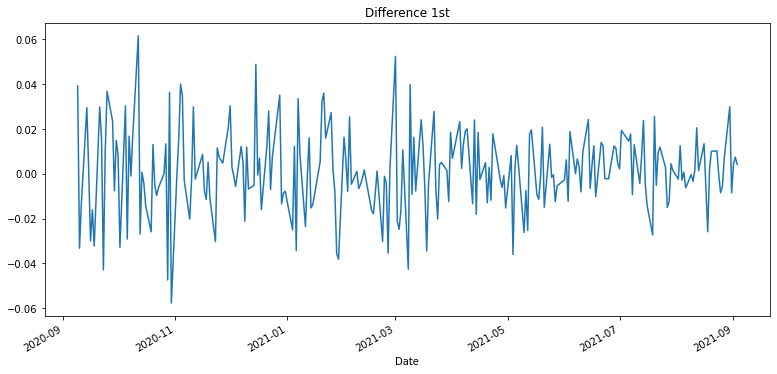

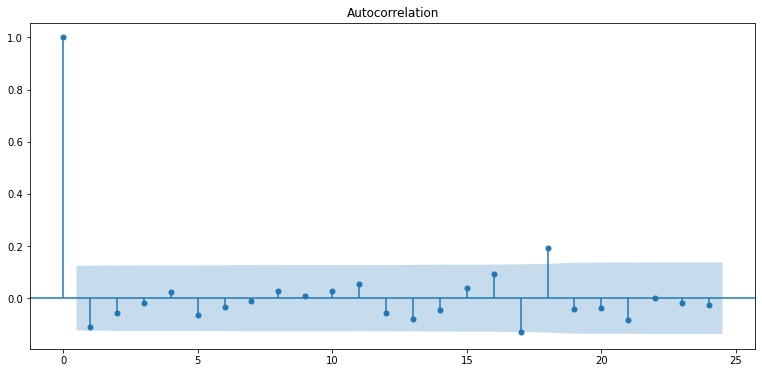

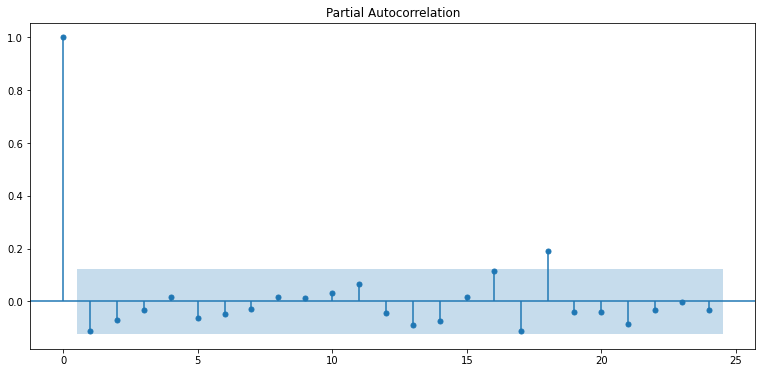

Results of Dickey-Fuller Test:
Test Statistic                -7.201193e+00
p-value                        2.363091e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


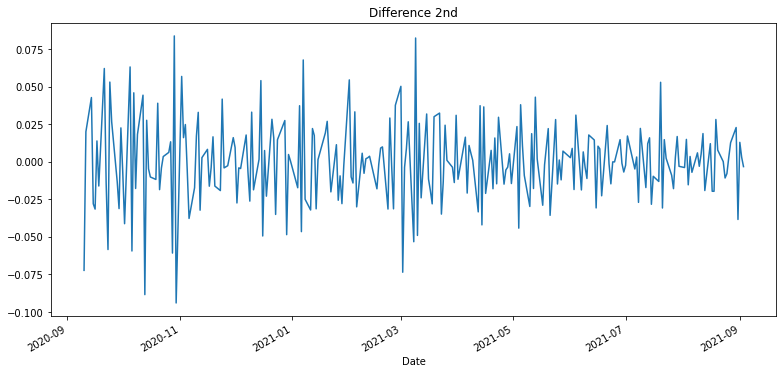

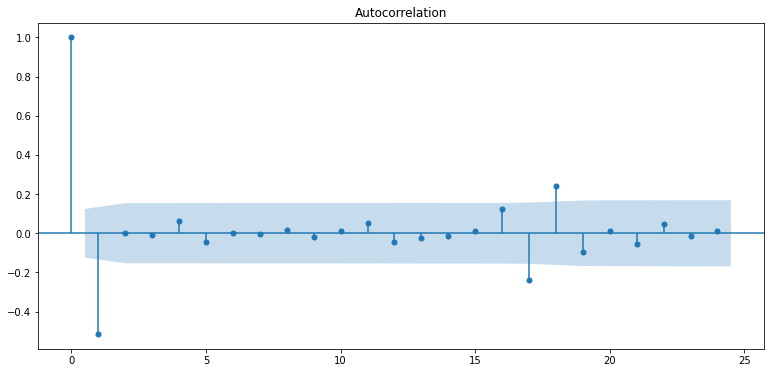

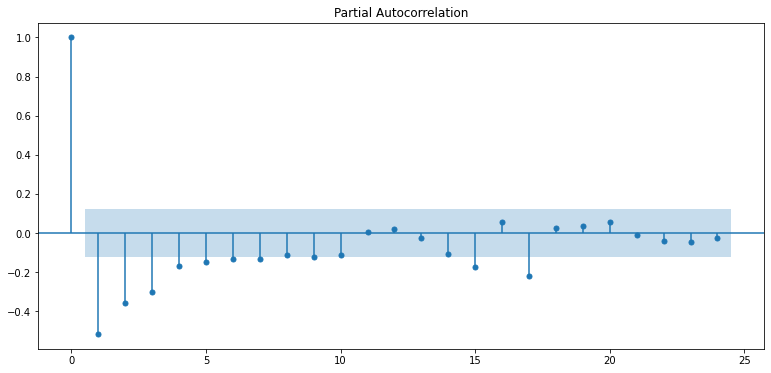

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  223
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 564.002
Method:                       css-mle   S.D. of innovations              0.019
Date:                Tue, 07 Sep 2021   AIC                          -1120.004
Time:                        04:12:58   BIC                          -1106.375
Sample:                             2   HQIC                         -1114.502
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.937e-06   1.77e-05      0.223      0.824   -3.07e-05    3.86e-05
ar.L1.D2.Close    -0.1146      0.067     -1.708      0.088      -0.246       0.017
ma.L1.D2.Close    -1.0000      0.013

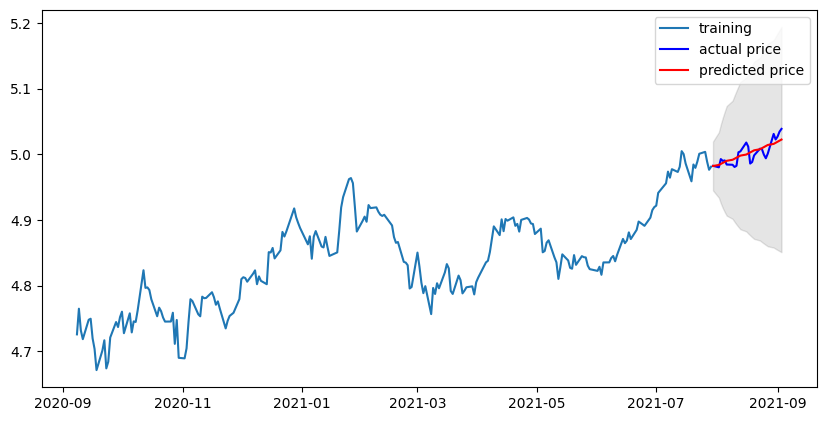

MSE:  2.6163149952274347
MAE:  1.3830288929154522
RMSE:  1.617502703313795
MAPE: 0.93%


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.


# 로그 변환
ts_log = np.log(ts)


# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

from statsmodels.tsa.arima_model import ARIMA

# Build and Train  Model
model = ARIMA(train_data, order=(1, 2, 1))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

* p=1, d=1, q=0 -> MAPE: 1.05%
* p=1, d=1, q=1 -> MAPE: 1.03%
* q=1, d=2, q=0 -> MAPE: 4.76%
* q=1, d=2, q=1 -> MAPE: 0.93%

## 8. 회고

* 모델의 정확도를 높이기 위해서는 적절한 ARIMA 모수를 찾는 것이 중요하다. 하지만, 적절한 ARIMA 모수를 찾는 것은 어려운 작업이다. ARIMA 모수를 찾기 위해서, 로그 변환 값과 1차 차분, 2차 차분 값을 모두 이용했다. 그 후, 각각의 데이터를 이용하여 ACF와 PACF 그래프를 그렸고, 모든 데이터를 종합적으로 판단하여 ARIMA 모수(p, d, q)를 결정하고자 하였다. 내가 판단한 근거가 정확했는지를 확인하기 위해서, 각각의 p, d, q값을 이용하여 MAPE를 계산했다.

### case 1

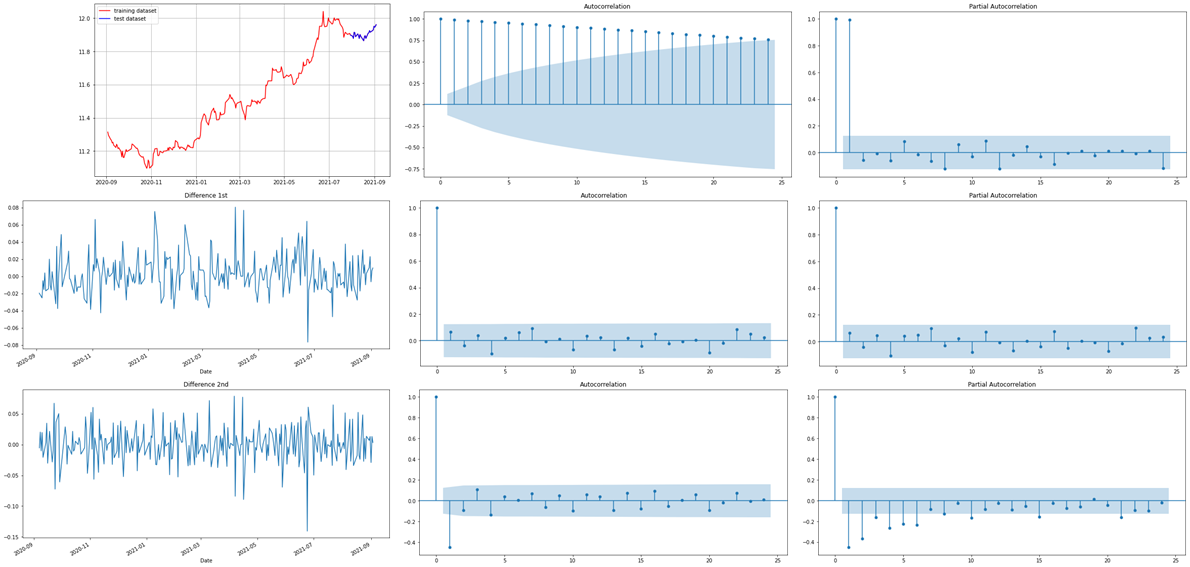

* p=1, d=1, q=0 -> MAPE: 3.61%
* p=1, d=1, q=1 -> MAPE: 3.32%
* q=1, d=2, q=0 -> MAPE: 4.50%
* q=1, d=2, q=1 -> MAPE: 8.73%
  
  
* case 1의 경우, 1차 차분 대부분의 데이터가 ACF와 PACF가 파란색 범주 안에 포함되는 것을 확인할 수 있다. 따라서, p, q의 값을 1로 설정하는 것이 좋다고 판단했다. 또한 로그 변환 데이터의 PACF 그래프를 보면, 대부분의 값이 파란색 범주 안에 속했지만, 1차 차분한 데이터가 더 많이 포함되는 것을 보아, q 값이 0보다는 1이 적절하다고 판단할 수 있었다. 이런 판단이 정확했는지를 확인하기 위해서, p는 1로 고정하고, q 값을 0, 1 두 가지로 선택하여 데스트를 진행했다. (2차 차분의 경우, PACF 그래프에서, 1차 차분보다 더 많은 데이터들이 범주에 속하지 못했다.) 
* d 값은 차분 데이터를 보고 판단하는 값인데, d 값을 판단하는 것이 가장 어려웠다. d 값을 판단하기 위해서는 차분의 정상성을 판단해야한다고 하는데, 정상성을 어떻게 판단할지, 어떤 측면으로, 어떤 근거로 판단해야하는지 파악하기 어려웠다. 또한, 1차 차분과 2차 차분 그래프가 비슷한 양상으로 그려졌다. 따라서, d 값을 1과 2 둘 다 사용하여 MAPE 값을 비교하기로 결정했다.
* q의 경우, 내가 예상했던 것 처럼, 0보다 1일때 더 좋은 MAPE 값을 갖는 것으로 확인되었다. d의 경우, 2보다는 1의 값을 가질 때, 더 좋은 값을 갖는 것으로 확인되었다. p와 q를 어떻게 설정할지 어느정도 감을 잡았지만, d의 경우에는 데이터를 보고 어떻게 설정해야할지 아직도 모르겠다.

### case 2

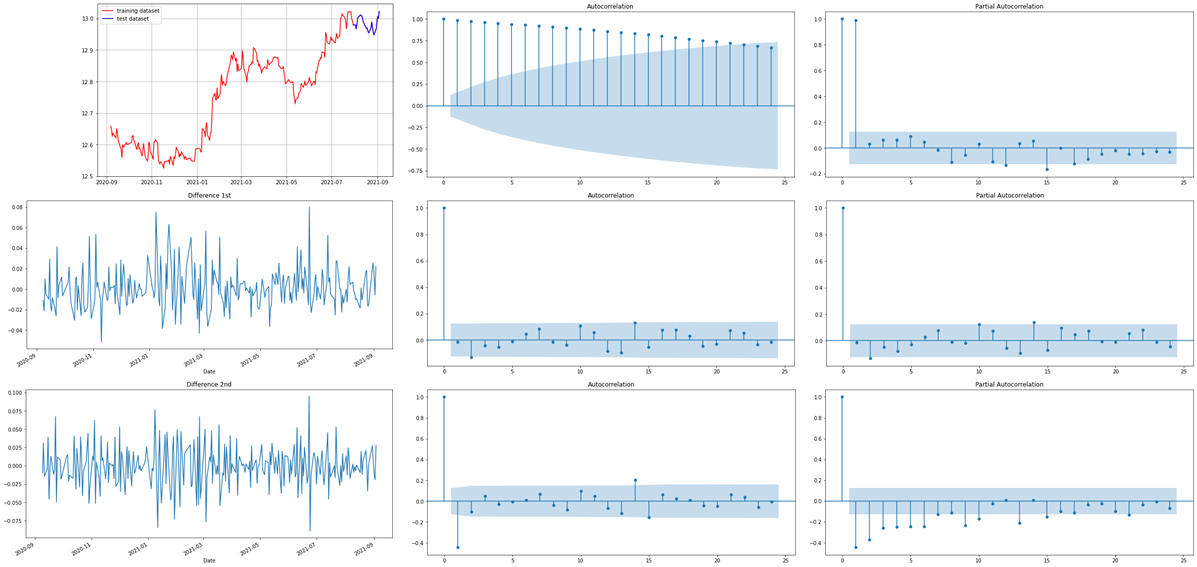

* p=1, d=1, q=0 -> MAPE: 3.14%
* p=1, d=1, q=1 -> MAPE: 3.51%
* q=1, d=2, q=0 -> MAPE: 12.01%
* q=1, d=2, q=1 -> MAPE: 계산 불가
  
  
* case 2의 경우, 로그 변환 데이터와 1차 차분 데이터 대부분이 ACF와 PACF가 파란색 범주 안에 포함되는 것을 확인할 수 있다. 그러나, 0에 수렴하는 데이터들이 1차 차분보다 로그 변환 데이터에서 더 많이 나타났다. 따라서, q 값은 0으로 설정하는 것이 더 적절하다고 판단하였다.  

* d 값은 차분 데이터를 보고 판단하는 값인데, d 값을 판단하는 것이 가장 어려웠다. d 값을 판단하기 위해서는 차분의 정상성을 판단해야한다고 하는데, 정상성을 어떻게 판단할지, 어떤 측면으로, 어떤 근거로 판단해야하는지 파악하기 어려웠다. 또한, 1차 차분과 2차 차분 그래프가 비슷한 양상으로 그려졌다. 따라서, d 값을 1과 2 둘 다 사용하여 MAPE 값을 비교하기로 결정했다.

* q의 경우, 내가 예상했던 것 처럼, 1보다 0일때 더 좋은 MAPE 값을 갖는 것으로 확인되었다. d의 경우, 2보다는 1의 값을 가질 때, 더 좋은 값을 갖는 것으로 확인되었다. 이번 케이스는 1차 차분 데이터와 2차 차분 데이터가 case 1보다 더 유사했는데, d 값에 따른 MAPE 값의 차이가 굉장히 컸다. d 값에 대한 판단을 어떻게 해야하는지 전혀 모르겠다.

### case 3

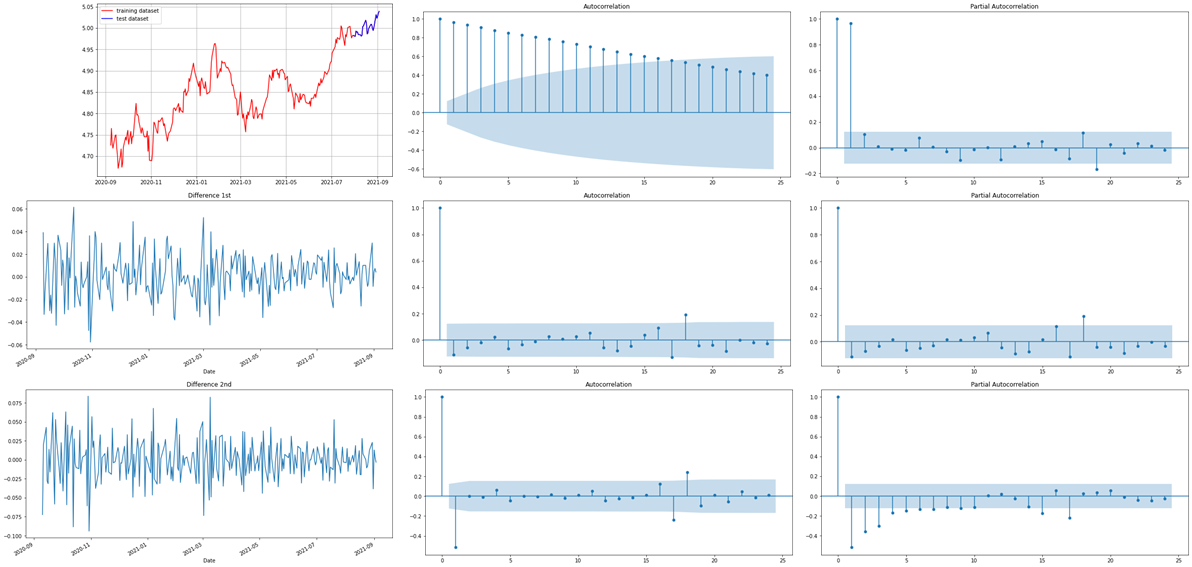

* p=1, d=1, q=0 -> MAPE: 1.05%
* p=1, d=1, q=1 -> MAPE: 1.03%
* q=1, d=2, q=0 -> MAPE: 4.76%
* q=1, d=2, q=1 -> MAPE: 0.93%
  
  
* case 3의 경우, 로그 변환 데이터와 1차 차분 데이터 대부분이 ACF와 PACF가 파란색 범주 안에 포함되는 것을 확인할 수 있다. 두 데이터 모두, 0으로 많이 수렴했기에 q 값이 0과 1일때의 차이가 거의 없다고 판단했다. 

* d 값은 차분 데이터를 보고 판단하는 값인데, d 값을 판단하는 것이 가장 어려웠다. d 값을 판단하기 위해서는 차분의 정상성을 판단해야한다고 하는데, 정상성을 어떻게 판단할지, 어떤 측면으로, 어떤 근거로 판단해야하는지 파악하기 어려웠다. 또한, 1차 차분과 2차 차분 그래프가 비슷한 양상으로 그려졌다. 따라서, d 값을 1과 2 둘 다 사용하여 MAPE 값을 비교하기로 결정했다.

* q의 경우, 내가 예상했던 것 처럼, 1과 0일때 MAPE 값의 차이가 거의 없는 것으로 확인되었다. 그러나, d의 경우, q=0 일때, MAPE 값이 많이 떨어졌지만, q=1 일때 MAPE 값이 더 좋아졌다. 도대체 근거가 무엇일까? 세 가지 케이스들에 대해서 아무리 살펴봐도, d 값을 판단할만한 근거에 대해서 전혀 이해하지 못하겠다. 왜 이런 내용이 노드에는 없었을까? 어쩌면, d 값은 직접 결과를 보고 판단해야하는 값일까?

* 이번 노드는 굉장히 재미없는 노드였다. 개인적으로 주식, 코인에 대해서 아무런 관심이 없기 때문일 수도 있지만, 어려운 내용, 감을 잡기 힘든 내용에 대한 정확한 설명, 자료 등이 없었고, 판단 근거에 대한 힌트도 없어서 재미가 없었던 것 같기도 하다. 아직도 d 값을 어떻게 판단해야 하는지에 대해서 감을 못잡았다. 이번 노드에 대한 솔직하고 개인적인 평은, '이걸 왜 해야하는가'이다. 뭔가를 배웠다기보다는, 그냥 'ARIMA 모델이라는 게 있구나' 정도의 노드였던 것 같다. 데이터를 분석하는 노드에 대해서는 분석에 대한 근거, 방법 등이 정확하게 설명되어 있거나, 그에 대한 힌트가 주어져야 한다고 생각한다.